In [ ]:
!pip install gdown
#Just the first time in order to retrieve the images to be patched
!gdown https://drive.google.com/uc?id=1iJ3O6mZduuaf_97eszLzVLyU5SaLvBE1
!unzip /content/Development_Dataset.zip

In [ ]:
#Patched images
!gdown https://drive.google.com/uc?id=1lFfDcDvnPhZsHByjc1KauyEbydN22sN3
!unzip /content/Develpment.zip

In [3]:
import os
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input 
import time
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from torch.nn import functional as f
import torch
import cv2
import math
import json


SEED = 1234
tf.random.set_seed(SEED)  

In [4]:
cwd = os.getcwd()


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)
  
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    return new_mask_arr

In [7]:
# ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [8]:

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [9]:
test_path_temp = '/content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images' 
test_elements_temp = getListOfFiles(test_path_temp)

In [ ]:
# Patching
# The following eight scripts have been used in order to properly fill the folders with patched images of the images themselves, 
# the masks and to fill the txt used in performing data augmentation. All the initial images are retrieved from Development_Dataset.
# Do not execute them
# Build up the forder of test img patched
def patcher (image):   
  img = cv2.imread(image) 
  name = os.path.basename(image)
  name = name[:len(name)-4]
  img_shape = img.shape
  tile_size = (256, 256)
  offset = (256, 256)
  for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Test_Dev/" + name + "_" + str(i) + "_" + str(j) + '.jpg' , cropped_img)
          
  

In [ ]:
patch_test_img = False
if patch_test_img:
  for k in range(len(test_elements_temp)): 
    patched_img = patcher(test_elements_temp[k])

In [ ]:
#Put the patched images into the folders. Here is shown how the folder unzipped in the second script has been created
redo_folders = False 

images = getListOfFiles("Development_Dataset/Images")
masks =  getListOfFiles("Development_Dataset/Masks")
if (redo_folders):
  patched_img = []
  patched_masks = []
  tile_size = (256, 256)
  offset = (256, 256)
  for image in images:
    img = cv2.imread(image) 
    img_shape = img.shape
    name = os.path.basename(image)
    name = name[:len(name)-4]
    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Images/"+  name + "_" + str(i) + "_" + str(j) + '.jpg', cropped_img)
  for mask in masks:
    img = cv2.imread(mask) 
    img_shape = img.shape
    name = os.path.basename(mask)
    name = name[:len(name)-4]
    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Masks/" + name + "_" + str(i) + "_" + str(j) + '.png' , cropped_img)



In [ ]:
#Fill the train and validation txt 
fill = False
if fill:
  img_names = getListOfFiles("/content/drive/My Drive/Develpment/Images")
  bound = 3352  #equals to 70 images
  count = 0
  train_img = []
  val_img = []
  for image in img_names:
    name = os.path.basename(image)
    name = name[:len(name)-4]
    if (count < bound ):
      train_img.append(name)
      train_img.append(" \n")
    else:
      val_img.append(name)
      val_img.append(" \n")
    count = count+1


In [ ]:
#val_file = open("/content/drive/My Drive/Develpment/Splits/val.txt","w")
#val_file.writelines(val_img)

In [ ]:
#train_file = open("/content/drive/My Drive/Develpment/Splits/train.txt","w")
#train_file.writelines(train_img)

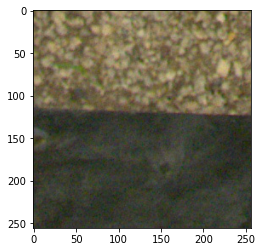

In [ ]:
#first patching technique - Example on one specific image 
patching_test1 = False
if (patching_test1):
  from sklearn.feature_extraction import image
  from torch.nn import functional as f
  import torch
  one_img =Image.open("Development_Dataset/Images/Bipbip_haricot_im_06481.jpg")
  one_img = np.array(one_img)
  tensor = torch.tensor(one_img)
  patches = tensor.unfold(0, 256, 256).unfold(1, 256, 256).unfold(2, 3, 3)
  list_of_patches = []
  ratio_1 = 8
  ratio_2 = 6
  for x in range(ratio_2):
      for y in range(ratio_1):
        list_of_patches.append(np.array(patches[x][y][0]))

  fig, ax = plt.subplots(1, 1)
  patche= patches[5][2][0]
  patche = np.array(patche)
  ax.imshow(np.uint8(patche))
  plt.show()

  #re = patches.permute(0, 3, 1, 4, 2, 5).contiguous().view_as(tensor)
  #print((re == tensor).all())




48

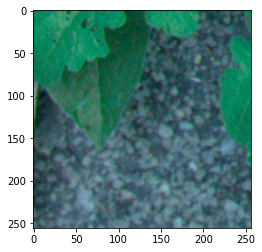

In [ ]:
#Second patching technique - Example on one specific image
patching_test2 = False
if (patching_test2):
  img = cv2.imread("Development_Dataset/Images/Bipbip_haricot_im_06481.jpg") 
  img_shape = img.shape
  tile_size = (256, 256)
  offset = (256, 256)
  lista = []
  for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          lista.append(cropped_img)
  fig, ax = plt.subplots(1, 1)
  len(np.array(lista))
  patche = np.array(lista[33])
  ax.imshow(np.uint8(patche))
  plt.show()

In [10]:
class CustomDataset(tf.keras.utils.Sequence):


  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[ 256,256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):

    # Read Image 
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
    
    
    # Resize image and mask 

    img = img.resize(self.out_shape)
    
    img_arr = np.array(img)

    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds to the contours of the objects. We remove it for simplicity.
    
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            curr_class_arr = np.uint8(curr_class_arr)
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [11]:
img_h = 256
img_w = 256
dataset = CustomDataset('/content/Develpment', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen)
dataset_valid = CustomDataset('/content/Develpment', 'validation')

In [12]:
bs = 16
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w,3], [img_h, img_w,1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [13]:
#Test data generator

%matplotlib inline

# Assign a color to each class

evenly_spaced_interval = np.linspace(0, 1, 20)

colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

TensorShape([256, 256, 3])

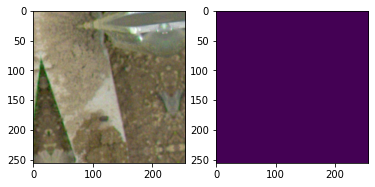

In [14]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   
augmented_img = augmented_img   
augmented_img.shape

target = np.array(target[0, ..., 0])  

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(0,3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target))

plt.show()



In [76]:
from keras.applications.vgg16 import VGG16 as VGG16, preprocess_input

from keras import models, layers

input_img = layers.Input((256,256,3), name = 'RGB_Input')

# output and start upsampling
encode_model = VGG16(input_shape=(256,256,3), include_top=False, weights='imagenet')

conv_1 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(encode_model.output)  # need to pass the output tensor to the conv_1 layer
up_conv = layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(conv_1)

# first concatenation block
concat_1 = layers.concatenate([encode_model.get_layer('block5_conv3').output, up_conv], axis=-1, name='concat_1')
conv_2 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(concat_1)
up_conv_2 = layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(conv_2)


# second concatenation block
concat_2 = layers.concatenate([up_conv_2, encode_model.get_layer('block4_conv3').output])
conv_3 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(concat_2)
up_conv_3 = layers.Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same')(conv_3)

# third concatenation block
concat_3 = layers.concatenate([up_conv_3, encode_model.get_layer('block3_conv3').output])
conv_4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(concat_3)
up_conv_4 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(conv_4)

# fourth concatenation block
concat_4 = layers.concatenate([up_conv_4, encode_model.get_layer('block2_conv2').output])
conv_5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(concat_4)
up_conv_5 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(conv_5)

# fifth concatenation block
concat_4 = layers.concatenate([up_conv_5, encode_model.get_layer('block1_conv2').output])
conv_6 = layers.Conv2D(3, (1,1), activation='softmax', padding='same')(concat_4)

final_model = models.Model(inputs=encode_model.input, outputs=[conv_6])
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [60]:
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def meanIoU(y_true, y_pred):
    
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(0,3): 
      
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics

metrics = ['accuracy', meanIoU]


# Compile Model
final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
train = False
if (train):
  

  cwd = os.getcwd()

  exps_dir = os.path.join(cwd, 'drive/MyDrive/Keras4/', 'multiclass_segmentation_experiments')
  if not os.path.exists(exps_dir):
     os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  model_name = 'CNN'

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []


  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                  save_best_only=True, save_weights_only=True)  
  callbacks.append(ckpt_callback)



  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    

  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  
  callbacks.append(tb_callback)

# Early Stopping

  early_stop = True
  if early_stop:
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights= True)
      callbacks.append(es_callback)


  final_model.fit(x=train_dataset,
          epochs=100,  
          steps_per_epoch=len(dataset)/bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, 
          callbacks=callbacks)



In [77]:
#Full fine tuning
final_model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec19_09-39-56/ckpts/cp_09.ckpt')

In [78]:
#Prepare Submission
def rle_encode(img):
    ''' img: numpy array, 1 - foreground, 0 - background.Returns run length as string formatted'''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [79]:
#Retrieve the patched test images
test_path = '/content/Develpment/Test_Dev' 
test_elements = getListOfFiles(test_path)

In [80]:
def compute_prediction(list_of_pathces):        #general function used for computing a prediction for each patch[to be assembled later]

  predictions_single_img = []
  for patch in list_of_pathces:
    patch = tf.expand_dims(patch, 0)
    out_sigmoid = final_model.predict(patch)
    predicted_mask = tf.argmax(out_sigmoid, -1)               #masks
    mask_arr = np.array(predicted_mask) 
    mask_arr = tf.squeeze(mask_arr)                    #converted
    predictions_single_img.append(np.array(mask_arr)) 

  return predictions_single_img

In [81]:
#Reordering the list of patched images
final_list = []  #list of all the 15 global prediction
base = 8 

for i in range(len(test_elements_temp)):
  im = test_elements_temp[i]
  name = os.path.basename(im)
  name = name[:len(name)-4]
  patch_collection = []       #48 patch per image
  for i in range(6):          #retrieve all the patch for one image
    for j in range(8):
      path = "/content/Develpment/Test_Dev/" + name + "_" + str(i) + "_" + str(j) + '.jpg'
      
      img = cv2.imread(path)                 
      patch_collection.append(img)
  pred_collection = compute_prediction(patch_collection )
  ##reconstruction
  oriz_patches = []
  for u in range(6): #first element of the row
    total = pred_collection[u*base]
    for i in range(1,8):   #all other seven
      total = np.concatenate((total, pred_collection[i+u*base]),axis = 1)
    oriz_patches.append(total)
  #build all the 6 horizontal blocks together
  total = oriz_patches[0] 
  for k in range(1,6):
    total = np.concatenate((total, oriz_patches[k]),axis = 0)
  final_list.append(total)
  

In [82]:
len(final_list)

15

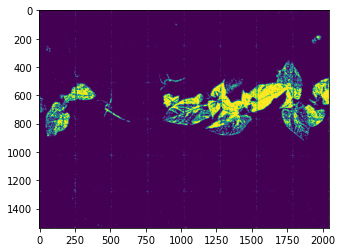

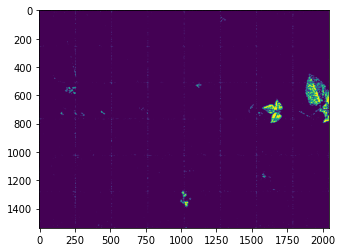

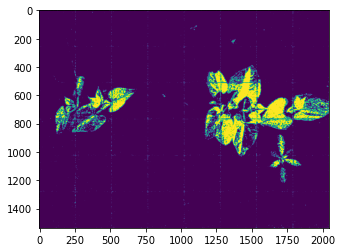

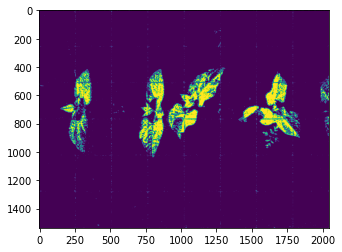

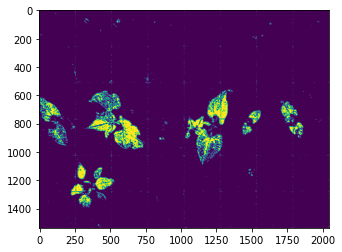

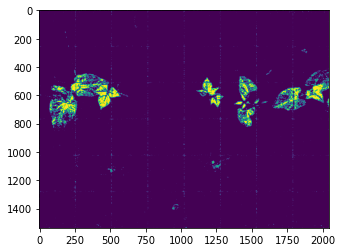

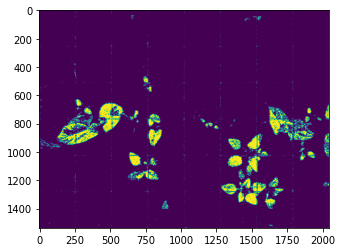

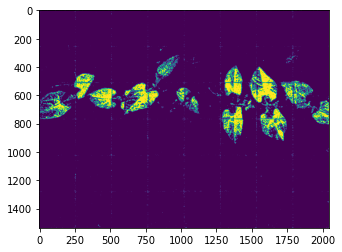

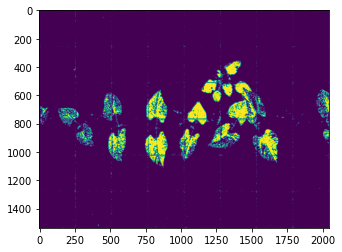

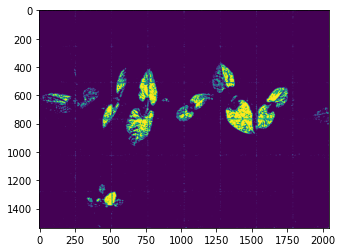

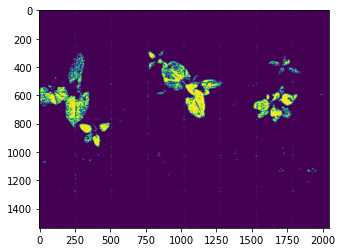

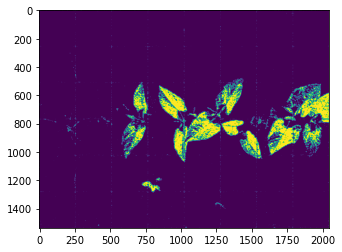

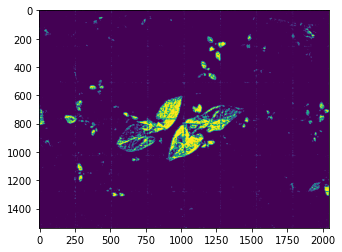

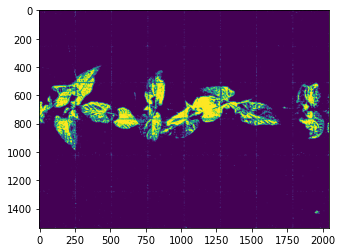

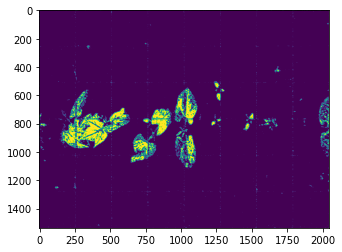

In [83]:
for el in final_list:
  fig, ax = plt.subplots(1, 1)
  ax.imshow(np.uint8(el))
  plt.show()

In [84]:
predictions = final_list
for i in range(len(predictions)):
  pred = predictions[i]
  #predictions[i] = np.array(pred) 

In [70]:
#Test_Dev is just a file containing all the other names in order to build up the json
!gdown https://drive.google.com/uc?id=17GZHCD4QDvRItngD-MRmNXOwgI5rU_9A
!unzip /content/Test_Dev.zip

Downloading...
From: https://drive.google.com/uc?id=17GZHCD4QDvRItngD-MRmNXOwgI5rU_9A
To: /content/Test_Dev.zip
499MB [00:03, 135MB/s]
Archive:  /content/Test_Dev.zip
replace __MACOSX/._Test_Dev? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [71]:
teams = ["Bipbip","Pead","Roseau","Weedelec"]
crops = ["Haricot","Mais"]

In [85]:
submission_dict = {}
i = 0
  #we perform the predictions only with a dataset, for the others it is required to put empty string for the submission
                          # Prediction dataset --> Haricot, Bipbip
for team in teams:
  for crop in crops:
    if ((team == "Bipbip") and (crop == "Haricot") ):
      for el in test_elements_temp:      #create all the keys, this might be redoundant code
        img_path = el
        img_name = os.path.basename(img_path)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
      for _id in predictions:        #Adding information for keys that matches the value
          img_path = test_elements_temp[i]
          i = i+1
          img_name = os.path.basename(img_path)
          img_name = img_name[:len(img_name)-4]
          submission_dict[img_name]['shape'] = _id.shape
          submission_dict[img_name]['team'] = team
          submission_dict[img_name]['crop'] = crop
          submission_dict[img_name]['segmentation'] = {}
          rle_encoded_crop = rle_encode(_id == 1)
          rle_encoded_weed = rle_encode(_id == 2)
          submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
          submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
    
    else:
      img_path = '/content/Test_Dev/'
      img_list = getListOfFiles(img_path + str(team) +'/' + str(crop) + '/Images')
      for img in img_list:     
        img_name = os.path.basename(img)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = (2048,1536)
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}
        submission_dict[img_name]['segmentation']['crop'] = ""
        submission_dict[img_name]['segmentation']['weed'] = ""

In [86]:

with open('submission.json', 'w') as f:   #dumps the dictionary into the json
  json.dump(submission_dict, f)

In [ ]:
submission_dict

In [34]:
from google.colab import files
files.download('submission.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

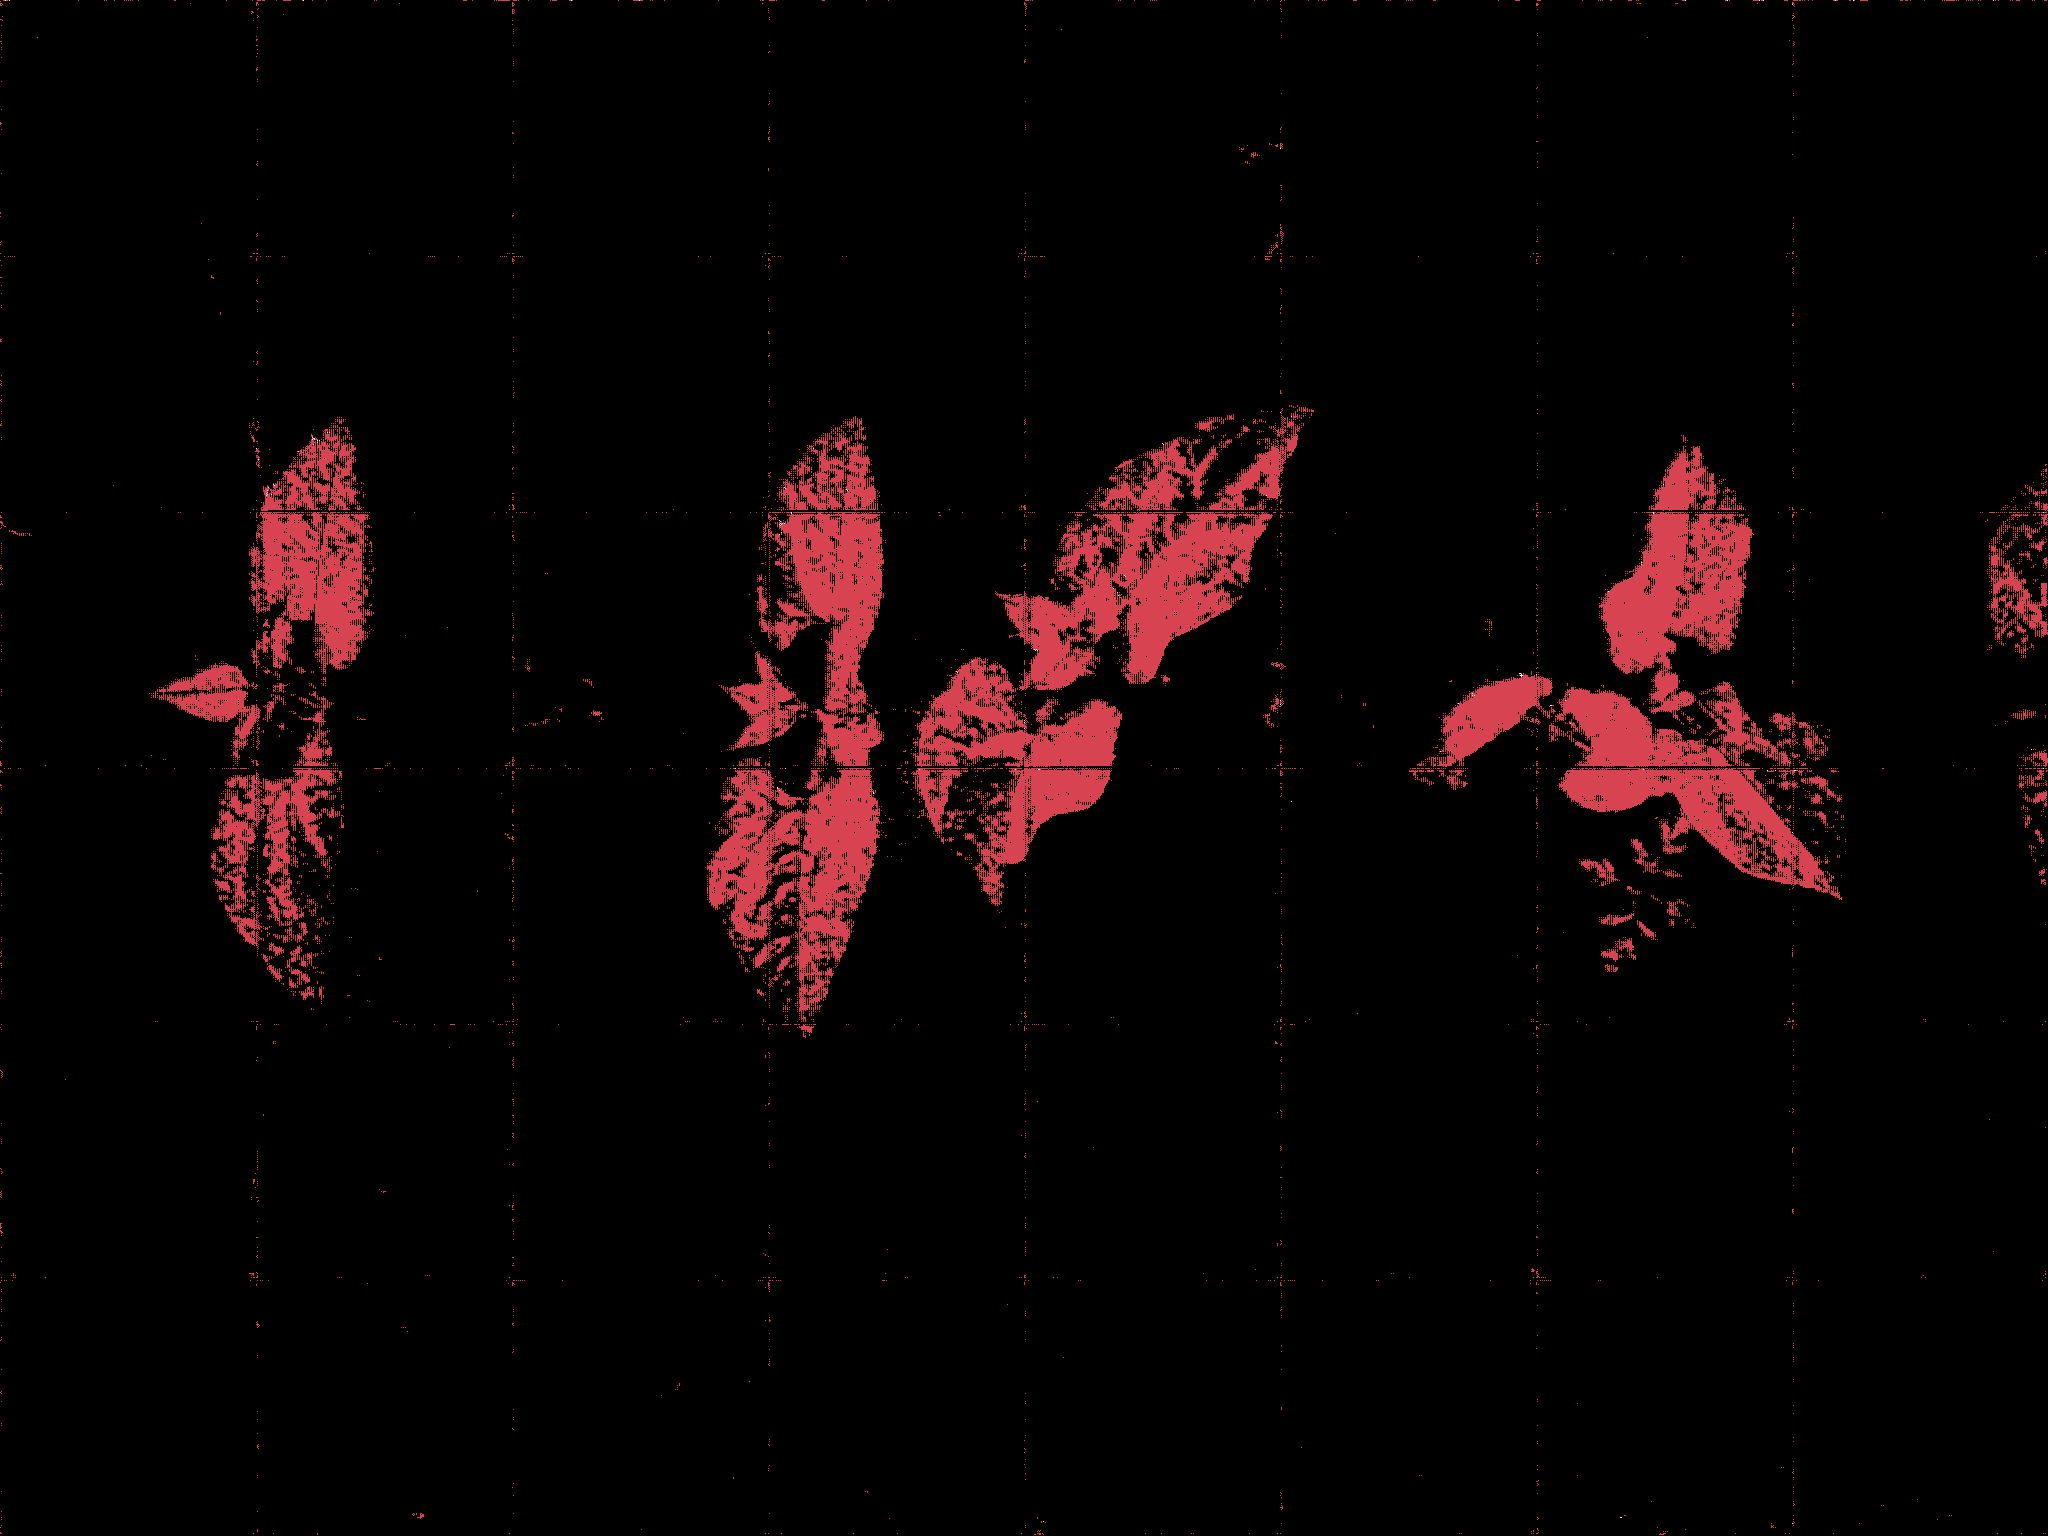

In [87]:
def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

decode = True
if decode:

    with open('submission.json', 'r') as f:
        submission_dict = json.load(f)

    img_name = 'Bipbip_haricot_im_00211'
    img_shape = submission_dict[img_name]['shape']

    rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
    rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

    
    crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
    weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

    reconstructed_mask = crop_mask + (weed_mask * 2)
    reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
    reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
    reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

    reconstructed_rgb_img = Image.fromarray(
        np.uint8(reconstructed_rgb_arr))
    
    reconstructed_rgb_img